In [95]:
import pandas as pd
from hmmlearn.hmm import GaussianHMM
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
import matplotlib.pyplot as plt

FILE_PATH = "../shared_data_read_only/"
FILES = ("consumer_price_index.xlsx","Contacts.xlsx","Invoice and Opportunities.xlsx",
         "Items and Opportunities.xlsx","Non-Stock Items.xlsx","Opportunities.xlsx")

In [96]:
df_cpi = pd.read_excel(f"{FILE_PATH}{FILES[0]}",)
df_cpi =  df_cpi.set_index('Date')
df_cpi = df_cpi.sort_index()
df_cpi['consumer_price_index_diff'] = df_cpi['consumer_price_index'].pct_change().fillna(0) # differentiating -> stationnary
df_cpi.head()

,consumer_price_index,consumer_price_index_diff
Date,,
2019-01-01,103.01,0.000000
2019-02-01,103.06,0.000485
2019-03-01,103.89,0.008054
2019-04-01,104.22,0.003176
2019-05-01,104.33,0.001055


In [97]:
df_cpi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 56 entries, 2019-01-01 to 2023-08-01
Data columns (total 2 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   consumer_price_index       56 non-null     float64
 1   consumer_price_index_diff  56 non-null     float64
dtypes: float64(2)
memory usage: 1.3 KB


In [98]:
df_cpi.describe()

,consumer_price_index,consumer_price_index_diff
count,56.000000,56.000000
mean,108.310536,0.002571
std,4.748734,0.003976
min,103.010000,-0.005645
25%,104.575000,0.000000
50%,106.030000,0.002028
75%,112.597500,0.004430
max,118.890000,0.014228


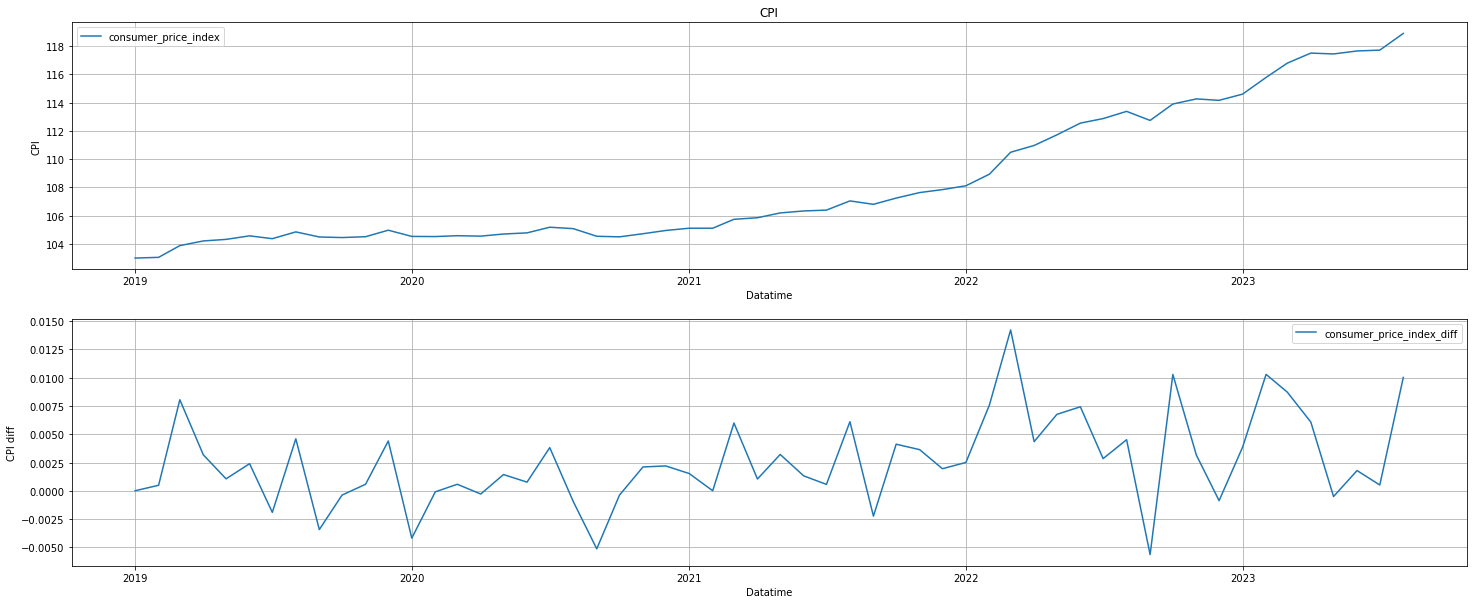

In [99]:
fig, ax = plt.subplots(2, 1, figsize=(25, 10))

ax[0].plot(df_cpi.index,df_cpi['consumer_price_index'],label="consumer_price_index")
ax[0].set_title(f"CPI")
ax[0].yaxis.set_label_text("CPI")
ax[0].xaxis.set_label_text("Datatime")
# ax[0].set_yscale("log")
ax[0].legend()
ax[0].grid()
ax[1].plot(df_cpi.index,df_cpi['consumer_price_index_diff'],label="consumer_price_index_diff")

ax[1].yaxis.set_label_text("CPI diff")
ax[1].xaxis.set_label_text("Datatime")
ax[1].legend()
ax[1].grid()


In [152]:
file_no = 2 # Invoice
df_invoice = pd.read_excel(f"{FILE_PATH}{FILES[file_no]}")
print(f"File : {FILES[file_no]}")

df_invoice_agg = (df_invoice.groupby(by=["Date"])
              .agg({"Opportunity ID":"count","Amount":'sum'})
              .resample("MS")
              .agg({"Opportunity ID":"sum","Amount":'sum'}))

df_invoice_agg.head()

File : Invoice and Opportunities.xlsx


,Opportunity ID,Amount
Date,,
2020-01-01,1,350000.00
2020-02-01,0,0.00
2020-03-01,1,3000.00
2020-04-01,1,209.08
2020-05-01,1,436988.09


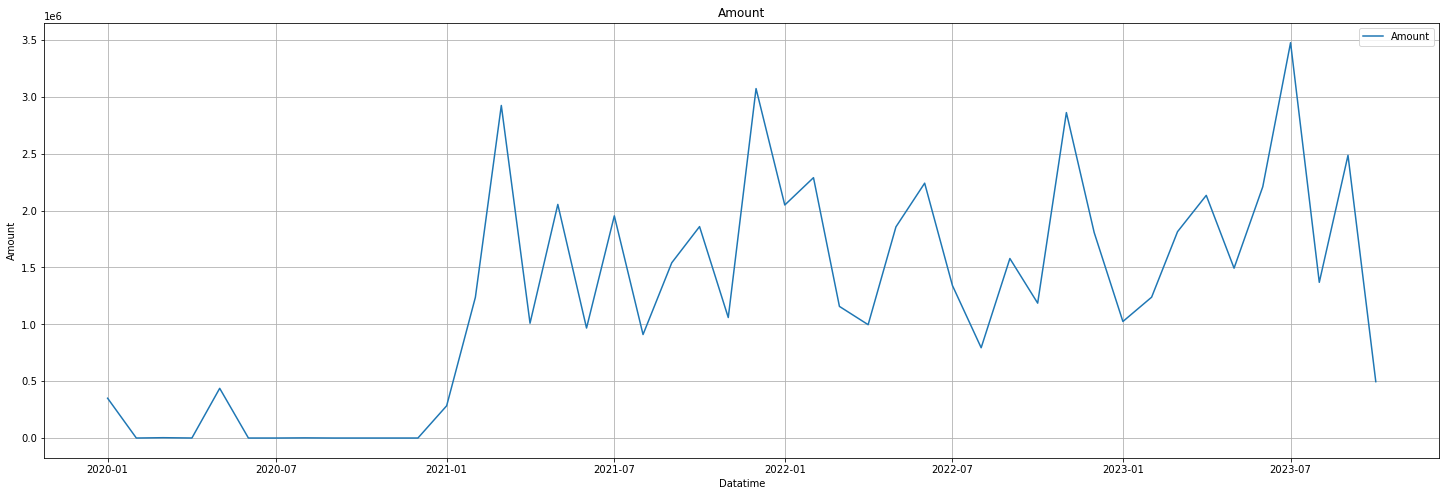

In [101]:
fig, ax = plt.subplots(1, 1, figsize=(25, 8))

ax.plot(df_invoice_agg.index,df_invoice_agg.Amount,label='Amount')
ax.set_title(f"Amount")
ax.yaxis.set_label_text("Amount")
ax.xaxis.set_label_text("Datatime")
ax.legend()
ax.grid()


In [133]:
df_merged_cpi_invoice = pd.merge(df_invoice_agg, df_cpi, left_index=True, right_index=True).loc['2021-01-01':]
df_merged_cpi_invoice.head()

,Opportunity ID,Amount,consumer_price_index,consumer_price_index_diff
Date,,,,
2021-01-01,17,283466.91,105.12,0.001524
2021-02-01,46,1236812.39,105.12,0.000000
2021-03-01,101,2923682.43,105.75,0.005993
2021-04-01,50,1009514.52,105.86,0.001040
2021-05-01,239,2053851.04,106.20,0.003212


In [149]:
scaler = RobustScaler()
consumer_price_index_diff_scaled = df_merged_cpi_invoice.consumer_price_index.to_numpy().reshape(-1, 1)#scaler.fit_transform(df_merged_cpi_invoice.consumer_price_index_diff.to_numpy().reshape(-1, 1))

model = GaussianMixture(n_components=2, covariance_type="full", random_state=42,max_iter=1000) # 2 Market Regimes
model.fit(consumer_price_index_diff_scaled)
consumer_price_index_diff_predicted = model.predict(consumer_price_index_diff_scaled)
df_merged_cpi_invoice['GM_regime'] = consumer_price_index_diff_predicted

df_merged_cpi_invoice.head()

,Opportunity ID,Amount,consumer_price_index,consumer_price_index_diff,HMM_regime,GM_regime
Date,,,,,,
2021-01-01,17,283466.91,105.12,0.001524,0,0
2021-02-01,46,1236812.39,105.12,0.000000,0,0
2021-03-01,101,2923682.43,105.75,0.005993,0,0
2021-04-01,50,1009514.52,105.86,0.001040,0,0
2021-05-01,239,2053851.04,106.20,0.003212,0,0


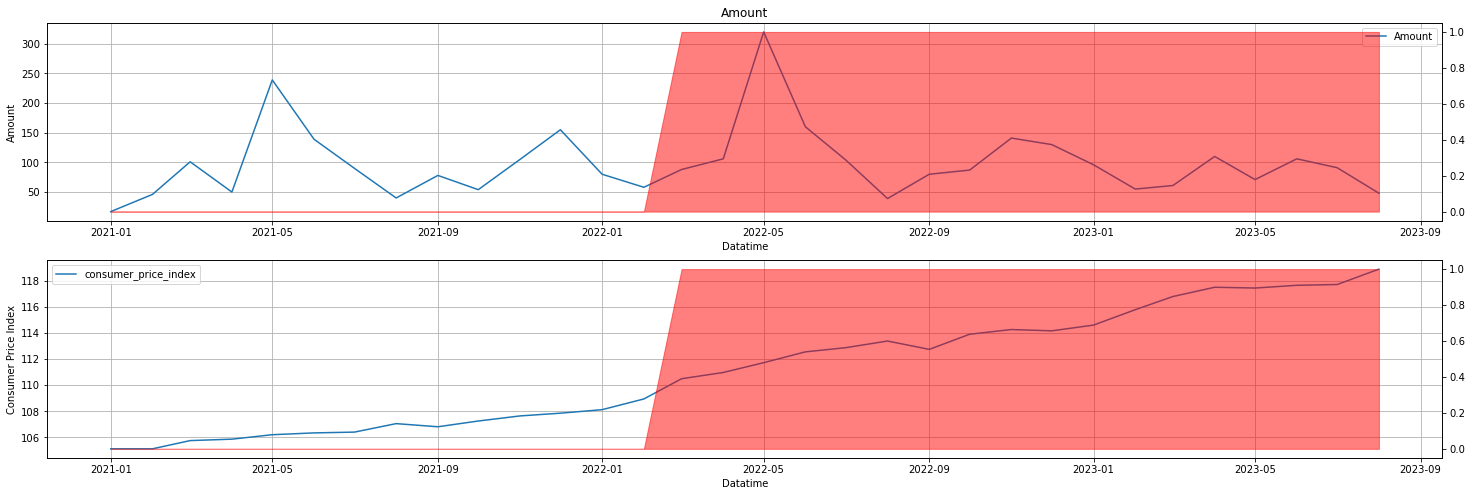

In [151]:
fig, ax = plt.subplots(2, 1, figsize=(25, 8))

ax[0].plot(df_merged_cpi_invoice.index,df_merged_cpi_invoice['Opportunity ID'],label='Amount')
ax_l = ax[0].twinx()
ax_l.fill_between(df_merged_cpi_invoice.index,df_merged_cpi_invoice.GM_regime,color='red',alpha=0.5)
ax[0].set_title(f"Amount")
ax[0].yaxis.set_label_text("Amount")
ax[0].xaxis.set_label_text("Datatime")
ax[0].legend()
ax[0].grid()

ax[1].plot(df_merged_cpi_invoice.index,df_merged_cpi_invoice.consumer_price_index,label='consumer_price_index')
ax_l = ax[1].twinx()
ax_l.fill_between(df_merged_cpi_invoice.index,df_merged_cpi_invoice.GM_regime,color='red',alpha=0.5)
ax[1].yaxis.set_label_text("Consumer Price Index")
ax[1].xaxis.set_label_text("Datatime")
ax[1].legend()
ax[1].grid()
